# Preprocessing Keyboard Data

Three types of data are recorded.

1. Old data: Data for Basem and Brian. Using first iteration of keyboard_recorder.
2. research: Originally from the KeyStroke dataset used in the paper. Only the non-Zoom audio
3. New Data: New data recorded after the new keyboard_recorder was made.

Steps for pulling together data

1. Load the data folders
2. Preprocess the files by extracting keystrokes (personal method vs Keystroke method)
3. Encode and format data together across all folders.


End result:
* One pickle file of tabular data
* One folder of data preprocessed for multi-modal modal



In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import yaml
import librosa
import librosa.display
import soundfile as sf
import shutil
import torch
import glob
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

## Old Data before rework (Basem, Brian)

In [20]:
# Define the path to the data folder
data_folder = '../data/old_data/'
output_dir='../preprocessed_data/'
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)  # Delete the folder and its contents
os.makedirs(output_dir)

# Initialize an empty list to store the data
key_data_list = []
sentence_data_list = []

# Loop through all user folders in the data folder
for user_folder in os.listdir(data_folder):
    if 'Keystroke' in user_folder:
        continue
    user_folder_path = os.path.join(data_folder, user_folder)
    if os.path.isdir(user_folder_path):  # Check if it's a directory
        key_folder_path = os.path.join(user_folder_path, 'data', 'key_data')
        sentence_folder_path = os.path.join(user_folder_path, 'data', 'sentence_data')

        # Key data, then sentence data
        # for internal_folder in [key_folder_path, sentence_folder_path]:
        for file_name in os.listdir(key_folder_path):
            # key_folder_path = os.path.join(data_folder, user_folder)
            # Check if the file is a YAML file
            if file_name.endswith('.yaml'):
                # Extract key_pressed value from the filename
                key_pressed = file_name.split('_')[2]
                
                # Construct the full path to the YAML file
                yaml_file_path = os.path.join(key_folder_path, file_name)
                
                # Read the YAML file and filter out the 'key_pressed' field and subsequent lines until 'keyboard_name'
                with open(yaml_file_path, 'r') as file:
                    lines = file.readlines()
                
                filtered_lines = []
                skip = False
                for line in lines:
                    if line.strip().startswith('key_pressed:'):
                        skip = True
                    if skip and line.strip().startswith('keyboard_name:'):
                        skip = False
                    if not skip:
                        filtered_lines.append(line)
                
                # Load the filtered lines into a dictionary
                yaml_data = yaml.safe_load(''.join(filtered_lines))
                
                # Add the user, audio file name, and key_pressed information
                yaml_data['user'] = user_folder
                # yaml_data['audio_file'] = file_name.replace('.yaml', f'_{user_folder}.wav')
                # original_file = file_name.replace('.yaml', '.wav')
                yaml_data['audio_file'] = file_name.replace('.yaml', '.wav') # Assuming audio files are in .wav format
                yaml_data['key_pressed'] = key_pressed

                # Copy the audio file to the output directory
                original_audio_file = yaml_data['audio_file']
                new_audio_file_name = original_audio_file.replace('.wav', f'_{user_folder}.wav')
                source_audio_file_path = os.path.join(key_folder_path, original_audio_file)
                destination_audio_file_path = os.path.join(output_dir, new_audio_file_name)
                shutil.copy2(source_audio_file_path, destination_audio_file_path)
                yaml_data['audio_file'] = new_audio_file_name
                key_data_list.append(yaml_data)

# Convert the list of dictionaries to a DataFrame
key_df = pd.DataFrame(key_data_list)
sentence_df = pd.DataFrame(sentence_data_list)

# Display the DataFrame
key_df.head()

,default_high_input_latency,default_high_output_latency,default_low_input_latency,default_low_output_latency,default_samplerate,hostapi,index,keyboard_name,keyboard_size,keyboard_type,max_input_channels,max_output_channels,name,switch_color,timestamp,user,audio_file,key_pressed
0,0.18,0.18,0.09,0.09,44100.0,0,1,DropCTRLV1,80%_Tenkeyless,mechanical,2,0,Mic/Inst (Samson G-Track Pro),Halo True,1720383597,Basem,key_press_z_1720383597_Basem.wav,z
1,0.18,0.18,0.09,0.09,44100.0,0,1,DropCTRLV1,80%_Tenkeyless,mechanical,2,0,Mic/Inst (Samson G-Track Pro),Halo True,1720383403,Basem,key_press_k_1720383403_Basem.wav,k
2,0.18,0.18,0.09,0.09,44100.0,0,1,DropCTRLV1,80%_Tenkeyless,mechanical,2,0,Mic/Inst (Samson G-Track Pro),Halo True,1720380835,Basem,key_press_4_1720380835_Basem.wav,4
3,0.18,0.18,0.09,0.09,44100.0,0,1,DropCTRLV1,80%_Tenkeyless,mechanical,2,0,Mic/Inst (Samson G-Track Pro),Halo True,1720383189,Basem,key_press_f_1720383189_Basem.wav,f
4,0.18,0.18,0.09,0.09,44100.0,0,1,DropCTRLV1,80%_Tenkeyless,mechanical,2,0,Mic/Inst (Samson G-Track Pro),Halo True,1720383147,Basem,key_press_d_1720383147_Basem.wav,d


### New Data

Find the peak for each audio file, then seperate them out.

In [21]:
def calculate_energy(y, sr):
    stft_result = np.abs(librosa.stft(y))
    energy = np.sum(stft_result**2, axis=0)
    energy = energy / np.max(energy)
    return energy

def sliding_window_average(energy, window_size):
    averaged_energy = np.convolve(energy, np.ones(window_size)/window_size, mode='same')
    return averaged_energy

def get_yaml_file(folder_path):
    for file in os.listdir(folder_path):
        if (file.endswith(".yaml") or file.endswith(".yml")):
            yaml_file_path = os.path.join(folder_path, file)
            # Get all yaml data first
            # Read the YAML file and filter out the 'key_pressed' field and subsequent lines until 'keyboard_name'
            with open(yaml_file_path, 'r') as file:
                lines = file.readlines()
            
            # Load the filtered lines into a dictionary
            yaml_data = yaml.safe_load(''.join(lines))
            
            # Add the user, audio file name, and key_pressed information
            user_keyboard_name = yaml_data['keyboard_name']
            user_keyboard_size = yaml_data['keyboard_size']
            keyboard_type = yaml_data['keyboard_type']
            switch_color = yaml_data['switch_color']
            return user_keyboard_name, user_keyboard_size, keyboard_type, switch_color
    return None

def extract_keystrokes(data_folder, low_threshold, high_threshold, output_dir,
                       window_size=50, target_duration=1.0, give_plot=False, debug=False):
    
    for user_folder in os.listdir(data_folder):
        if 'Keystroke' in user_folder:
            continue
        user_folder_path = os.path.join(data_folder, user_folder)
        audio_data = []
        if os.path.isdir(user_folder_path):  # Check if it's a directory
            key_folder_path = os.path.join(user_folder_path, 'key_data')
            user_keyboard_name, user_keyboard_size, keyboard_type, switch_color = get_yaml_file(key_folder_path)
            if not key_folder_path:
                raise('Yaml file for data not found')

            for file_name in os.listdir(key_folder_path):
                if file_name.endswith('.yaml'):
                    continue
                        
                elif file_name.endswith('.wav'):
                    # Wav file
                    key_pressed = file_name.split('_')[2].lower()

                    wav_file_path = os.path.join(key_folder_path, file_name)

                    y, sr = librosa.load(wav_file_path, sr=None)
                    energy = calculate_energy(y, sr)
                    averaged_energy = sliding_window_average(energy, window_size)
                    
                    keystroke_indices = np.where(averaged_energy > low_threshold)[0]
                    
                    keystroke_events = []
                    if len(keystroke_indices) > 0:
                        start_idx = keystroke_indices[0]
                        for i in range(1, len(keystroke_indices)):
                            if keystroke_indices[i] - keystroke_indices[i-1] > 1:
                                end_idx = keystroke_indices[i-1]
                                keystroke_events.append((start_idx, end_idx))
                                start_idx = keystroke_indices[i]
                        keystroke_events.append((start_idx, keystroke_indices[-1]))
                    
                    filtered_keystroke_events = []
                    for start_frame, end_frame in keystroke_events:
                        if np.max(averaged_energy[start_frame:end_frame]) > high_threshold:
                            length = end_frame - start_frame
                            extension = int(0.1 * length)
                            start_frame = max(0, start_frame - extension)
                            end_frame = min(len(averaged_energy), end_frame + extension)
                            filtered_keystroke_events.append((start_frame, end_frame))
                    
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    
                    for i, (start_frame, end_frame) in enumerate(filtered_keystroke_events[1:]):
                        start_sample = librosa.frames_to_samples(start_frame)
                        end_sample = librosa.frames_to_samples(end_frame + 1)
                        
                        keystroke_audio = y[start_sample:end_sample]
                        
                        # Calculate required padding
                        target_samples = int(target_duration * sr)
                        current_samples = len(keystroke_audio)
                        padding_needed = target_samples - current_samples
                        if padding_needed > 0:
                            pad_before = padding_needed // 2
                            pad_after = padding_needed - pad_before
                            keystroke_audio = np.pad(keystroke_audio, (pad_before, pad_after), 'constant')
                        
                        output_path = os.path.join(output_dir, f'key_press_{key_pressed}_{i}_{user_folder}.wav')
                        sf.write(output_path, keystroke_audio, sr)
                        if debug:
                            print(f'Saved keystroke {i} to {output_path}')
                        
                        # Write the filename and additional data to a dataframe.
                        audio_data.append([user_keyboard_name,
                                           user_keyboard_size, 
                                           keyboard_type,
                                           switch_color,
                                           f'key_press_{key_pressed}_{i}_{user_folder}.wav',
                                           key_pressed])

                    if give_plot:
                        # Plot for visualization
                        time = np.linspace(0, len(y) / sr, len(y))
                        frames_time = np.linspace(0, len(energy) * window_size / sr, len(energy))
                        
                        plt.figure(figsize=(15, 7))
                        # plt.plot(time, y, label='Audio Signal')
                        plt.plot(frames_time, averaged_energy, label='Averaged Energy', color='orange')
                        plt.axhline(y=low_threshold, color='black', linestyle=':', label='Low Threshold')
                        plt.axhline(y=high_threshold, color='green', linestyle=':', label='High Threshold')
                        for start_frame, end_frame in filtered_keystroke_events[1:]:
                            plt.axvline(x=start_frame * window_size / sr, color='red', linestyle='-', linewidth=0.2)
                            plt.axvline(x=end_frame * window_size / sr, color='magenta', linestyle='-', linewidth=0.2)
                        plt.xlabel('Time (s)')
                        plt.ylabel('Amplitude / Averaged Energy')
                        plt.legend()
                        plt.title('Keystroke Detection Visualization')
                        plt.show()
    key_df = pd.DataFrame(data=audio_data, columns=['keyboard_name', 'keyboard_size', 'keyboard_type',
                                                    'switch_color', 'audio_file', 'key_pressed'])
    return key_df

# Extract keystrokes with the chosen threshold
audio_path='../data/new_data/'
low_threshold=0.005  # Thresholds must be adjusted
high_threshold=0.01  # Thresholds must be adjusted
output_dir='../preprocessed_data/'
window_size=35
give_plot=False

new_key_df = extract_keystrokes(data_folder=audio_path,
                   low_threshold=low_threshold,
                   high_threshold=high_threshold,
                   output_dir=output_dir,
                   window_size=window_size,
                   give_plot=False)
new_key_df.head()

,keyboard_name,keyboard_size,keyboard_type,switch_color,audio_file,key_pressed
0,Dropctrlv1,80%_Tenkeyless,mechanical,Halo True,key_press_`_0_Newman.wav,`
1,Dropctrlv1,80%_Tenkeyless,mechanical,Halo True,key_press_`_1_Newman.wav,`
2,Dropctrlv1,80%_Tenkeyless,mechanical,Halo True,key_press_`_2_Newman.wav,`
3,Dropctrlv1,80%_Tenkeyless,mechanical,Halo True,key_press_`_3_Newman.wav,`
4,Dropctrlv1,80%_Tenkeyless,mechanical,Halo True,key_press_`_4_Newman.wav,`


-------------

Continue here. Function above now works. 

1. Need to grab original audio data
2. Need a combination function for all dataframes

### Grab original audio research data. (not done)

In [22]:
# Extract keystrokes with the chosen threshold
audio_path='../data/research/'
low_threshold=0.005  # Thresholds must be adjusted
high_threshold=0.01  # Thresholds must be adjusted
output_dir='../preprocessed_data/'
window_size=35
give_plot=False

research_df = extract_keystrokes(data_folder=audio_path,
                   low_threshold=low_threshold,
                   high_threshold=high_threshold,
                   output_dir=output_dir,
                   window_size=window_size,
                   give_plot=give_plot)
research_df.head()

,keyboard_name,keyboard_size,keyboard_type,switch_color,audio_file,key_pressed
0,MacbookProM1,65%_Compact(Default for Macbooks),Scissor,None,key_press_5_0_MBPWavs.wav,5
1,MacbookProM1,65%_Compact(Default for Macbooks),Scissor,None,key_press_5_1_MBPWavs.wav,5
2,MacbookProM1,65%_Compact(Default for Macbooks),Scissor,None,key_press_5_2_MBPWavs.wav,5
3,MacbookProM1,65%_Compact(Default for Macbooks),Scissor,None,key_press_5_3_MBPWavs.wav,5
4,MacbookProM1,65%_Compact(Default for Macbooks),Scissor,None,key_press_5_4_MBPWavs.wav,5


### Combine all three dataframes

In [23]:
combined_key_df = pd.concat([key_df, new_key_df, research_df], ignore_index=True)
combined_key_df.head()

,default_high_input_latency,default_high_output_latency,default_low_input_latency,default_low_output_latency,default_samplerate,hostapi,index,keyboard_name,keyboard_size,keyboard_type,max_input_channels,max_output_channels,name,switch_color,timestamp,user,audio_file,key_pressed
0,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,DropCTRLV1,80%_Tenkeyless,mechanical,2.0,0.0,Mic/Inst (Samson G-Track Pro),Halo True,1.720384e+09,Basem,key_press_z_1720383597_Basem.wav,z
1,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,DropCTRLV1,80%_Tenkeyless,mechanical,2.0,0.0,Mic/Inst (Samson G-Track Pro),Halo True,1.720383e+09,Basem,key_press_k_1720383403_Basem.wav,k
2,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,DropCTRLV1,80%_Tenkeyless,mechanical,2.0,0.0,Mic/Inst (Samson G-Track Pro),Halo True,1.720381e+09,Basem,key_press_4_1720380835_Basem.wav,4
3,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,DropCTRLV1,80%_Tenkeyless,mechanical,2.0,0.0,Mic/Inst (Samson G-Track Pro),Halo True,1.720383e+09,Basem,key_press_f_1720383189_Basem.wav,f
4,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,DropCTRLV1,80%_Tenkeyless,mechanical,2.0,0.0,Mic/Inst (Samson G-Track Pro),Halo True,1.720383e+09,Basem,key_press_d_1720383147_Basem.wav,d


---------
---------
---------
## Begin processing data

## Add Keyboard Material Column

In [24]:
print(np.unique([name.lower().replace(" ", "") for name in combined_key_df['keyboard_name'].values]))

['dropctrlv1' 'keychronq3' 'macbookprom1']


In [25]:
material_mapper = {'dropctrlv1': 'aluminum',
                   'keychronq3': 'aluminum',
                   'macbookprom1': 'aluminum'}
combined_key_df['keyboard_name'] = combined_key_df['keyboard_name'].apply(lambda x: x.lower().replace(" ", ""))
combined_key_df['keyboard_material'] = combined_key_df['keyboard_name'].map(material_mapper)
combined_key_df.drop('keyboard_name', axis=1, inplace=True)
combined_key_df.head()

,default_high_input_latency,default_high_output_latency,default_low_input_latency,default_low_output_latency,default_samplerate,hostapi,index,keyboard_size,keyboard_type,max_input_channels,max_output_channels,name,switch_color,timestamp,user,audio_file,key_pressed,keyboard_material
0,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,80%_Tenkeyless,mechanical,2.0,0.0,Mic/Inst (Samson G-Track Pro),Halo True,1.720384e+09,Basem,key_press_z_1720383597_Basem.wav,z,aluminum
1,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,80%_Tenkeyless,mechanical,2.0,0.0,Mic/Inst (Samson G-Track Pro),Halo True,1.720383e+09,Basem,key_press_k_1720383403_Basem.wav,k,aluminum
2,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,80%_Tenkeyless,mechanical,2.0,0.0,Mic/Inst (Samson G-Track Pro),Halo True,1.720381e+09,Basem,key_press_4_1720380835_Basem.wav,4,aluminum
3,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,80%_Tenkeyless,mechanical,2.0,0.0,Mic/Inst (Samson G-Track Pro),Halo True,1.720383e+09,Basem,key_press_f_1720383189_Basem.wav,f,aluminum
4,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,80%_Tenkeyless,mechanical,2.0,0.0,Mic/Inst (Samson G-Track Pro),Halo True,1.720383e+09,Basem,key_press_d_1720383147_Basem.wav,d,aluminum


## Add Keyboard Microhone Column cleanup

In [26]:
combined_key_df['name'].unique()

microphone_mapper = {'Mic/Inst (Samson G-Track Pro)': 'Samson_GTrack_Pro',
                     'Microphone (3- USB PnP Audio De': 'GenericPnP'}

combined_key_df['microphone'] = combined_key_df['name'].map(microphone_mapper)
combined_key_df.drop('name', axis=1, inplace=True)
combined_key_df.head()

,default_high_input_latency,default_high_output_latency,default_low_input_latency,default_low_output_latency,default_samplerate,hostapi,index,keyboard_size,keyboard_type,max_input_channels,max_output_channels,switch_color,timestamp,user,audio_file,key_pressed,keyboard_material,microphone
0,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,80%_Tenkeyless,mechanical,2.0,0.0,Halo True,1.720384e+09,Basem,key_press_z_1720383597_Basem.wav,z,aluminum,Samson_GTrack_Pro
1,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,80%_Tenkeyless,mechanical,2.0,0.0,Halo True,1.720383e+09,Basem,key_press_k_1720383403_Basem.wav,k,aluminum,Samson_GTrack_Pro
2,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,80%_Tenkeyless,mechanical,2.0,0.0,Halo True,1.720381e+09,Basem,key_press_4_1720380835_Basem.wav,4,aluminum,Samson_GTrack_Pro
3,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,80%_Tenkeyless,mechanical,2.0,0.0,Halo True,1.720383e+09,Basem,key_press_f_1720383189_Basem.wav,f,aluminum,Samson_GTrack_Pro
4,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,80%_Tenkeyless,mechanical,2.0,0.0,Halo True,1.720383e+09,Basem,key_press_d_1720383147_Basem.wav,d,aluminum,Samson_GTrack_Pro


## Drop unneeded columns

In [27]:
unnecessary_cols = ['default_high_input_latency',
                    'default_high_output_latency',
                    'default_low_input_latency',
                    'default_low_output_latency',
                    'default_samplerate',
                    'hostapi',
                    'index',
                    'max_input_channels',
                    'max_output_channels',
                    'timestamp',]
combined_key_df.drop(unnecessary_cols, axis=1, inplace=True)

In [28]:
combined_key_df[combined_key_df['key_pressed'] == 'p']

,keyboard_size,keyboard_type,switch_color,user,audio_file,key_pressed,keyboard_material,microphone
9,80%_Tenkeyless,mechanical,Halo True,Basem,key_press_p_1720382799_Basem.wav,p,aluminum,Samson_GTrack_Pro
87,80%_Tenkeyless,mechanical,Halo True,Basem,key_press_p_1720382827_Basem.wav,p,aluminum,Samson_GTrack_Pro
108,80%_Tenkeyless,mechanical,Halo True,Basem,key_press_p_1720382810_Basem.wav,p,aluminum,Samson_GTrack_Pro
146,80%_Tenkeyless,mechanical,Halo True,Basem,key_press_p_1720382820_Basem.wav,p,aluminum,Samson_GTrack_Pro
221,80%_Tenkeyless,mechanical,Halo True,Basem,key_press_p_1720382823_Basem.wav,p,aluminum,Samson_GTrack_Pro
245,80%_Tenkeyless,mechanical,Halo True,Basem,key_press_p_1720382803_Basem.wav,p,aluminum,Samson_GTrack_Pro
250,80%_Tenkeyless,mechanical,Halo True,Basem,key_press_p_1720382796_Basem.wav,p,aluminum,Samson_GTrack_Pro
316,80%_Tenkeyless,mechanical,Halo True,Basem,key_press_p_1720382806_Basem.wav,p,aluminum,Samson_GTrack_Pro
380,80%_Tenkeyless,mechanical,Halo True,Basem,key_press_p_1720382813_Basem.wav,p,aluminum,Samson_GTrack_Pro
465,80%_Tenkeyless,mechanical,Halo True,Basem,key_press_p_1720382817_Basem.wav,p,aluminum,Samson_GTrack_Pro


## One-hot encoding

keyboard sizes to ordinal encodings

In [29]:
# Let's do the keyboard
keyboard_sizes = {
    '100%_FullSize': 5,
    '96%_Compact': 4,
    '80%_Tenkeyless': 3,
    '75%_Compact_Tenkeyless': 2,
    '65%_Compact(Default for Macbooks)': 1,
    '60%_Mini': 0,
}

# Ordinally encode the 'keyboard_size' column
combined_key_df['keyboard_size'] = combined_key_df['keyboard_size'].map(keyboard_sizes)
# key_df.drop(['keyboard_size'], axis=1, inplace=True)
combined_key_df.head()

,keyboard_size,keyboard_type,switch_color,user,audio_file,key_pressed,keyboard_material,microphone
0,3,mechanical,Halo True,Basem,key_press_z_1720383597_Basem.wav,z,aluminum,Samson_GTrack_Pro
1,3,mechanical,Halo True,Basem,key_press_k_1720383403_Basem.wav,k,aluminum,Samson_GTrack_Pro
2,3,mechanical,Halo True,Basem,key_press_4_1720380835_Basem.wav,4,aluminum,Samson_GTrack_Pro
3,3,mechanical,Halo True,Basem,key_press_f_1720383189_Basem.wav,f,aluminum,Samson_GTrack_Pro
4,3,mechanical,Halo True,Basem,key_press_d_1720383147_Basem.wav,d,aluminum,Samson_GTrack_Pro


Switch_colors to switch_type
switch_type(clicky, tactile, linear, NA(membrane))


In [30]:
switches_dict = {
    'Clicky': [
        'Cherry MX Blue', 'Cherry MX Green', 'Cherry MX White',
        'Gateron Blue', 'Gateron Green',
    ],
    'Tactile': [
        'Cherry MX Brown', 'Cherry MX Clear',
        'Gateron Brown', 'Halo True', 'Halo Clear',
    ],
    'Linear': [
        'Cherry MX Red', 'Cherry MX Black', 'Cherry MX Silent Red', 'Cherry MX Speed Silver',
        'Gateron Red', 'Gateron Black', 'Gateron Silent Red', 'Gateron Yellow',
        'Cherry MX Grey', 'Gateron Clear', 'Gateron White',
    ],
    'None': ['None']
}

def map_switch_type(switch):
    for key, values in switches_dict.items():
        if switch in values:
            return key
    print(f"{switch} was not in any category. setting to NA")
    return 'NA'  # If switch doesn't match any category

# Apply the mapping function to the 'switch_type' column
combined_key_df['switch_type'] = combined_key_df['switch_color'].map(lambda x: map_switch_type(x))
combined_key_df.drop(['switch_color'], axis=1, inplace=True)

combined_key_df.head()

,keyboard_size,keyboard_type,user,audio_file,key_pressed,keyboard_material,microphone,switch_type
0,3,mechanical,Basem,key_press_z_1720383597_Basem.wav,z,aluminum,Samson_GTrack_Pro,Tactile
1,3,mechanical,Basem,key_press_k_1720383403_Basem.wav,k,aluminum,Samson_GTrack_Pro,Tactile
2,3,mechanical,Basem,key_press_4_1720380835_Basem.wav,4,aluminum,Samson_GTrack_Pro,Tactile
3,3,mechanical,Basem,key_press_f_1720383189_Basem.wav,f,aluminum,Samson_GTrack_Pro,Tactile
4,3,mechanical,Basem,key_press_d_1720383147_Basem.wav,d,aluminum,Samson_GTrack_Pro,Tactile


# I STOPPED HERE. WE NEED A DATAFRAME FOR PROCESSING VISUALiZATIONS!

In [ ]:
# Now do a dummies on it
combined_key_df = pd.get_dummies(combined_key_df, columns=['switch_type', 'keyboard_material'])
combined_key_df.head()

Key Pressed (y) encoding

In [13]:
# Encode the 'key_pressed' column using LabelEncoder
from sklearn.preprocessing import LabelEncoder
le_key_pressed = LabelEncoder()
combined_key_df['key_pressed'] = le_key_pressed.fit_transform(combined_key_df['key_pressed'])
# key_df['key_pressed']
combined_key_df.head()

,keyboard_size,keyboard_type,user,audio_file,key_pressed,microphone,switch_type_Linear,switch_type_None,switch_type_Tactile,keyboard_material_aluminum
0,3,mechanical,Basem,key_press_z_1720383597_Basem.wav,47,Samson_GTrack_Pro,False,False,True,True
1,3,mechanical,Basem,key_press_k_1720383403_Basem.wav,31,Samson_GTrack_Pro,False,False,True,True
2,3,mechanical,Basem,key_press_4_1720380835_Basem.wav,7,Samson_GTrack_Pro,False,False,True,True
3,3,mechanical,Basem,key_press_f_1720383189_Basem.wav,25,Samson_GTrack_Pro,False,False,True,True
4,3,mechanical,Basem,key_press_d_1720383147_Basem.wav,23,Samson_GTrack_Pro,False,False,True,True


Todo:
- Onehot encode switch_colors now that youve sorted them
- ordinally encode the keyboard sizes
- onehot encode the keyboard material(aluminum, plastic, wood)

## Final droppings

In [14]:
combined_key_df.drop(['user', 'microphone', 'keyboard_type', 'key_pressed'], axis=1, inplace=True)
combined_key_df.head()

,keyboard_size,audio_file,switch_type_Linear,switch_type_None,switch_type_Tactile,keyboard_material_aluminum
0,3,key_press_z_1720383597_Basem.wav,False,False,True,True
1,3,key_press_k_1720383403_Basem.wav,False,False,True,True
2,3,key_press_4_1720380835_Basem.wav,False,False,True,True
3,3,key_press_f_1720383189_Basem.wav,False,False,True,True
4,3,key_press_d_1720383147_Basem.wav,False,False,True,True


-----------

# Dropping material until new keyboard materials come(Remove this)

In [15]:
combined_key_df.drop(['keyboard_material_aluminum'], axis=1, inplace=True)
combined_key_df.head()

,keyboard_size,audio_file,switch_type_Linear,switch_type_None,switch_type_Tactile
0,3,key_press_z_1720383597_Basem.wav,False,False,True
1,3,key_press_k_1720383403_Basem.wav,False,False,True
2,3,key_press_4_1720380835_Basem.wav,False,False,True
3,3,key_press_f_1720383189_Basem.wav,False,False,True
4,3,key_press_d_1720383147_Basem.wav,False,False,True


----------------

Testing(Remove later)

In [16]:
combined_key_df[combined_key_df['switch_type_None'] == True]

,keyboard_size,audio_file,switch_type_Linear,switch_type_None,switch_type_Tactile
984,1,key_press_5_0_MBPWavs.wav,False,True,False
985,1,key_press_5_1_MBPWavs.wav,False,True,False
986,1,key_press_5_2_MBPWavs.wav,False,True,False
987,1,key_press_5_3_MBPWavs.wav,False,True,False
988,1,key_press_5_4_MBPWavs.wav,False,True,False
...,...,...,...,...,...
1835,1,key_press_3_19_MBPWavs.wav,False,True,False
1836,1,key_press_3_20_MBPWavs.wav,False,True,False
1837,1,key_press_3_21_MBPWavs.wav,False,True,False
1838,1,key_press_3_22_MBPWavs.wav,False,True,False


## Create a pickle file for the dataloader

Verify the size of this dataframe is the same as the size of the directory.

In [17]:
print(f"Number of tabular items: {combined_key_df.shape[0]}")
print(f"Number of audio files in the folder: {len(glob.glob('../preprocessed_data/*.wav'))}")

if combined_key_df.shape[0] == len(glob.glob('../preprocessed_data/*.wav')):
    print(f'Matching shapes. Outputting tabular pickle file.')
    combined_key_df.to_pickle('../preprocessed_data/keyboard_tabular_data.pkl')
else:
    raise('Error: Directory files are not the same length as the dataframe!')

Number of tabular items: 1840
Number of audio files in the folder: 1840
Matching shapes. Outputting tabular pickle file.


--------

### View an example key

/tmp/ipykernel_326136/192415009.py:10: FutureWarning: Pass y=[0.         0.         0.         ... 0.00088501 0.00085449 0.00088501] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=64, win_length=1024, hop_length=500)


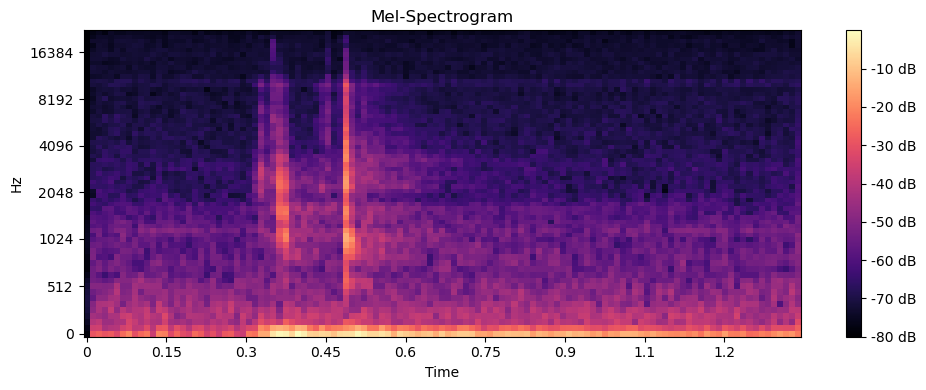

In [18]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load an audio file
filename = '../preprocessed_data/key_press_z_1720383587_Basem.wav'
samples, sr = librosa.load(filename, sr=None)

# Compute the mel-spectrogram
mel_spec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=64, win_length=1024, hop_length=500)

# Convert to decibels for better visualization
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Plot the mel-spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_db, sr=sr, hop_length=500, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.show()

TODO:
- Add a name abbreviation for each audio file for the respective folders
- convert Switches to clicky or non clicky
    - Clicky: 
        - Bumpy
        - loud noise
        - Blue, green
    - Tactile:
        Bumpy, moderate noise. You feel the bump before it actuates. Usually no sound (halo clears, mx clears)
        - Brown, clear
    - Linear:
        - Smooth
        - COnsistent, almost no noise
        - Red, Yellow, Black

Sound:
    - Switch itself
    - Heavy the switch itself is
    - Mechanism of switch
    - Case material (plastic, aluminum, brass, combo)
    - Design(hwo much empty space)
    - Floating keycap design or not
    - Keycaps(ABS, PBT)
    - thickness of keycap.
    - shape of keycap
    - Lubed or not
    - Stabilizers present? Are they modded or not?


* **mel-spectrograms** as a method of feature extraction for a DL mode

* Augmentation:
    * Signals were time-shifted randomly by up to 40% in either direction.
        - Helps increase amount of data
    * Mel-spectrograms generated using:
        * 64 mel brands
        * Window length of 1024 samples
        * hop length of 500 (255 for macbook keystrokes, given their shorter length)
        - results in 64x64 images
    * After Mel-spectrograms, complete masking:
        * take random 10% of both time and frequency axis and setting all values within those ranges to the mean of the spectrogram.
            - 'blocking out' a portion of the image.
            - Called SpecAugment and was foudn to encourage the model to generalise and avoid overfitting.
    